In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pickle
import numpy as np
from scipy.stats import iqr
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import matplotlib.pyplot as plt


In [2]:
# training parameters
epochs = 25
batch_size = 8
loss = tf.keras.losses.MeanAbsoluteError()
opt = tf.keras.optimizers.Adam()
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.95)
input_path = '../../data/generalize_test/'
output_path = './model/'


In [3]:
# load data
x_train = pickle.load(open(input_path+'/x_train.pkl', 'rb'))
y_train = pickle.load(open(input_path+'/y_train.pkl', 'rb'))
sizes_train = pickle.load(open(input_path+'/sizes_train.pkl', 'rb'))
x_val = pickle.load(open(input_path+'/x_test.pkl', 'rb'))
y_val = pickle.load(open(input_path+'/y_test.pkl', 'rb'))
sizes_val = pickle.load(open(input_path+'/sizes_test.pkl', 'rb'))


In [4]:
# standardize
x_train = [np.array(i) for i in x_train]
x_val = [np.array(i) for i in x_val]

y_train = [(i-j.mean())/j.std() for i,j in zip(y_train, x_train)]
y_val = [(i-j.mean())/j.std() for i,j in zip(y_val, x_val)]
x_train = [(i-i.mean())/i.std() for i in x_train]
x_val = [(i-i.mean())/i.std() for i in x_val]


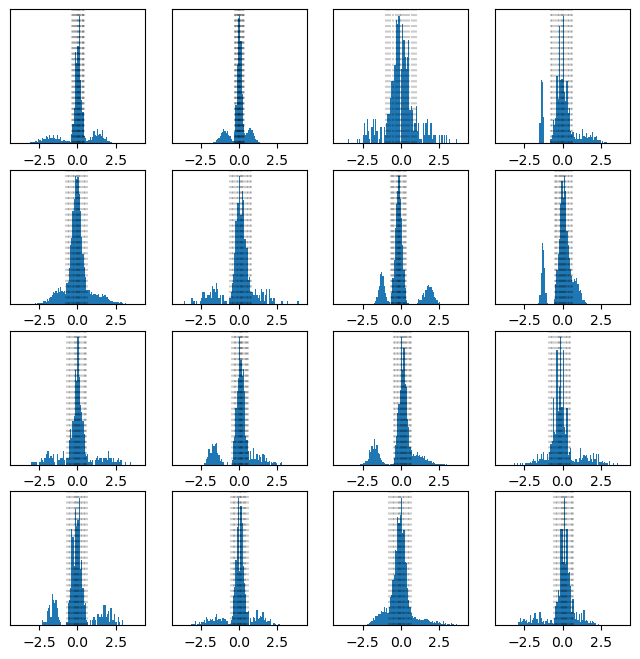

In [5]:
# plot example data points
nr = 4
nc = 4
plt.figure(figsize=(8,8))
idx = np.random.choice(len(x_train), nr*nc)
bins = np.linspace(-4, 4, 101)
for i in range(nr*nc):
    plt.subplot(nr, nc, i+1)
    plt.hist(x_train[idx[i]], bins, density=True)
    for j in range(len(y_train[0])):
        plt.axvline(y_train[idx[i]][j], c='k', linestyle=':', alpha=0.2)
    plt.yticks([])
    

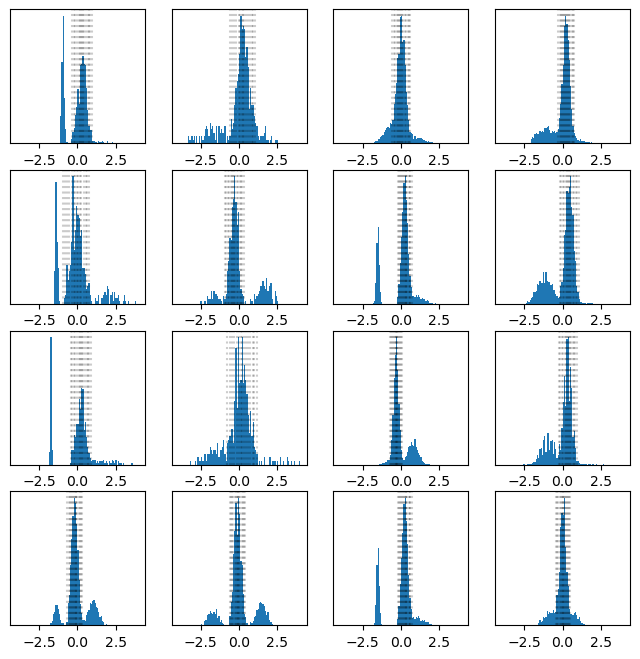

In [6]:
# plot example data points
nr = 4
nc = 4
plt.figure(figsize=(8,8))
idx = np.random.choice(len(x_val), nr*nc)
bins = np.linspace(-4, 4, 101)
for i in range(nr*nc):
    plt.subplot(nr, nc, i+1)
    plt.hist(x_val[idx[i]], bins, density=True)
    for j in range(len(y_val[0])):
        plt.axvline(y_val[idx[i]][j], c='k', linestyle=':', alpha=0.2)
    plt.yticks([])
    

In [7]:
# optionally add size prediction

y_train = np.array(y_train)
y_train = np.hstack([
    y_train, 
    np.array([i[0]/sum(i) for i in sizes_train]).reshape(-1, 1)
])

y_val = np.array(y_val)
y_val = np.hstack([
    y_val, 
    np.array([i[0]/sum(i) for i in sizes_val]).reshape(-1, 1)
])


In [8]:
def extract_features(data):

    features = np.histogram(data, np.linspace(-4, 4, 101), density=True)[0]
    features = (features - features.min())/(features.max() - features.min())
    
    return features.reshape(-1, 1)


In [9]:
# extract features
x_train = [extract_features(i) for i in x_train]
x_train = np.array(x_train)
x_val = [extract_features(i) for i in x_val]
x_val = np.array(x_val)


In [10]:
x_train.shape

(3000, 100, 1)

In [11]:
y_train.shape


(3000, 16)

In [12]:
# standardize

scalery = RobustScaler()
y_train = scalery.fit_transform(y_train)
y_val = scalery.transform(y_val)


In [13]:
# define model

inputs = tf.keras.layers.Input(shape=x_train.shape[1:])
x = tf.keras.layers.Conv1D(32, kernel_size=5, activation='relu')(inputs)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(64, kernel_size=5, activation='relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(64, kernel_size=7, activation='relu')(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.5)(x)
o = tf.keras.layers.Dense(y_val.shape[1], activation='linear')(x)
model = tf.keras.models.Model(inputs, o)

# define loss and optimizer
model.compile(loss = loss,
              optimizer = opt)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 96, 32)            192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 48, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 44, 64)            10304     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 22, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 16, 64)            28736 

In [14]:
# define best model checkpoint
checkpoint_path = output_path+'/model_checkpoint'
checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    save_weights_only=False,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    save_format='tf',
    verbose=1
)

# train
history = model.fit(
    x_train, 
    y_train,
    validation_data = (x_val, y_val),
    epochs = epochs,
    batch_size = batch_size,
    callbacks = [checkpoint_callback],
    verbose = 2
)

with open(output_path+'/model_history.npy', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)



Epoch 1/25


I0000 00:00:1716817975.178884   13404 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 0.57712, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


375/375 - 9s - loss: 0.3574 - val_loss: 0.5771 - 9s/epoch - 24ms/step
Epoch 2/25

Epoch 2: val_loss improved from 0.57712 to 0.55607, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


375/375 - 3s - loss: 0.1890 - val_loss: 0.5561 - 3s/epoch - 7ms/step
Epoch 3/25

Epoch 3: val_loss did not improve from 0.55607
375/375 - 2s - loss: 0.1651 - val_loss: 0.5910 - 2s/epoch - 5ms/step
Epoch 4/25

Epoch 4: val_loss improved from 0.55607 to 0.49009, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


375/375 - 3s - loss: 0.1538 - val_loss: 0.4901 - 3s/epoch - 8ms/step
Epoch 5/25

Epoch 5: val_loss did not improve from 0.49009
375/375 - 2s - loss: 0.1444 - val_loss: 0.5221 - 2s/epoch - 5ms/step
Epoch 6/25

Epoch 6: val_loss did not improve from 0.49009
375/375 - 2s - loss: 0.1390 - val_loss: 0.5361 - 2s/epoch - 5ms/step
Epoch 7/25

Epoch 7: val_loss improved from 0.49009 to 0.43399, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


375/375 - 3s - loss: 0.1272 - val_loss: 0.4340 - 3s/epoch - 7ms/step
Epoch 8/25

Epoch 8: val_loss did not improve from 0.43399
375/375 - 2s - loss: 0.1276 - val_loss: 0.4365 - 2s/epoch - 5ms/step
Epoch 9/25

Epoch 9: val_loss did not improve from 0.43399
375/375 - 2s - loss: 0.1218 - val_loss: 0.5113 - 2s/epoch - 5ms/step
Epoch 10/25

Epoch 10: val_loss did not improve from 0.43399
375/375 - 2s - loss: 0.1211 - val_loss: 0.4662 - 2s/epoch - 5ms/step
Epoch 11/25

Epoch 11: val_loss improved from 0.43399 to 0.39951, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


375/375 - 3s - loss: 0.1111 - val_loss: 0.3995 - 3s/epoch - 8ms/step
Epoch 12/25

Epoch 12: val_loss did not improve from 0.39951
375/375 - 2s - loss: 0.1163 - val_loss: 0.4381 - 2s/epoch - 5ms/step
Epoch 13/25

Epoch 13: val_loss did not improve from 0.39951
375/375 - 2s - loss: 0.1110 - val_loss: 0.4388 - 2s/epoch - 5ms/step
Epoch 14/25

Epoch 14: val_loss did not improve from 0.39951
375/375 - 2s - loss: 0.1065 - val_loss: 0.4656 - 2s/epoch - 5ms/step
Epoch 15/25

Epoch 15: val_loss did not improve from 0.39951
375/375 - 2s - loss: 0.1071 - val_loss: 0.4549 - 2s/epoch - 5ms/step
Epoch 16/25

Epoch 16: val_loss did not improve from 0.39951
375/375 - 2s - loss: 0.1080 - val_loss: 0.4277 - 2s/epoch - 5ms/step
Epoch 17/25

Epoch 17: val_loss did not improve from 0.39951
375/375 - 2s - loss: 0.1048 - val_loss: 0.4237 - 2s/epoch - 5ms/step
Epoch 18/25

Epoch 18: val_loss did not improve from 0.39951
375/375 - 2s - loss: 0.1100 - val_loss: 0.4190 - 2s/epoch - 5ms/step
Epoch 19/25

Epoch 19

INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


375/375 - 3s - loss: 0.1004 - val_loss: 0.3737 - 3s/epoch - 8ms/step
Epoch 20/25

Epoch 20: val_loss did not improve from 0.37369
375/375 - 2s - loss: 0.1001 - val_loss: 0.4360 - 2s/epoch - 5ms/step
Epoch 21/25

Epoch 21: val_loss did not improve from 0.37369
375/375 - 2s - loss: 0.0984 - val_loss: 0.4008 - 2s/epoch - 5ms/step
Epoch 22/25

Epoch 22: val_loss did not improve from 0.37369
375/375 - 2s - loss: 0.1003 - val_loss: 0.4683 - 2s/epoch - 5ms/step
Epoch 23/25

Epoch 23: val_loss did not improve from 0.37369
375/375 - 2s - loss: 0.0965 - val_loss: 0.4639 - 2s/epoch - 5ms/step
Epoch 24/25

Epoch 24: val_loss did not improve from 0.37369
375/375 - 2s - loss: 0.0950 - val_loss: 0.4648 - 2s/epoch - 5ms/step
Epoch 25/25

Epoch 25: val_loss improved from 0.37369 to 0.36842, saving model to ./model/model_checkpoint
INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


INFO:tensorflow:Assets written to: ./model/model_checkpoint/assets


375/375 - 3s - loss: 0.0935 - val_loss: 0.3684 - 3s/epoch - 7ms/step


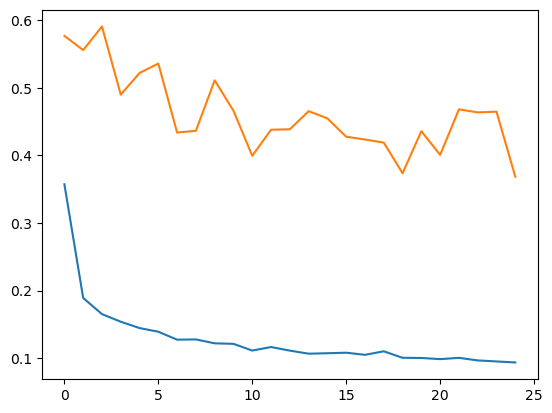

In [15]:
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);


In [16]:
# save scalers
with open(output_path+'/model_y_scaler.pkl', 'wb') as f:
    pickle.dump(scalery, f)
